<a href="https://colab.research.google.com/github/windapratiwi215/data-science-Project4-Churn-Prediction/blob/main/DS_Projek_4_Sandbox_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect G-Drive

In [290]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [291]:
import os
default_dir = "/content/drive/MyDrive/Colab Notebooks/Digital Skola/Projek-4"
os.chdir(default_dir)

In [292]:
!ls

 Churn_Modelling.csv  'DS Projek 4 Sandbox_Churn_Prediction.ipynb'


# Import Libraries

In [293]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import (
    train_test_split, KFold, cross_val_score,
    GridSearchCV, train_test_split,
)
from sklearn.preprocessing import (
    scale, LabelEncoder, StandardScaler,
    MinMaxScaler, Normalizer, RobustScaler
)

from sklearn.metrics import (
    classification_report, accuracy_score, f1_score,
    precision_score, confusion_matrix, recall_score,
    roc_auc_score, roc_curve
)

# to display all columns and rows:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# The number of numbers that will be shown after the comma.
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 1.&nbsp;Load Dataset

## 1.1 Description

Data Set Story:
- It consists of 10000 observations and 12 variables.
- Independent variables contain information about customers.
- Dependent variable refers to customer abandonment.


Features:
- Surname: Surname
- CreditScore: Credit score
- Geography: Country (Germany / France / Spain)
- Gender: Gender (Female / Male)
- Age: Age
- Tenure: How many years of customer
- Balance: Balance
- NumOfProducts: Bank product used
- HasCrCard: Credit card status (0 = No, 1 = Yes)
- IsActiveMember: Active membership status (0 = No, 1 = Yes)
- EstimatedSalary: Estimated salary
- Exited: Abandoned or not? (0 = No, 1 = Yes)

In [294]:
df = pd.read_csv("Churn_Modelling.csv", index_col=0)
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


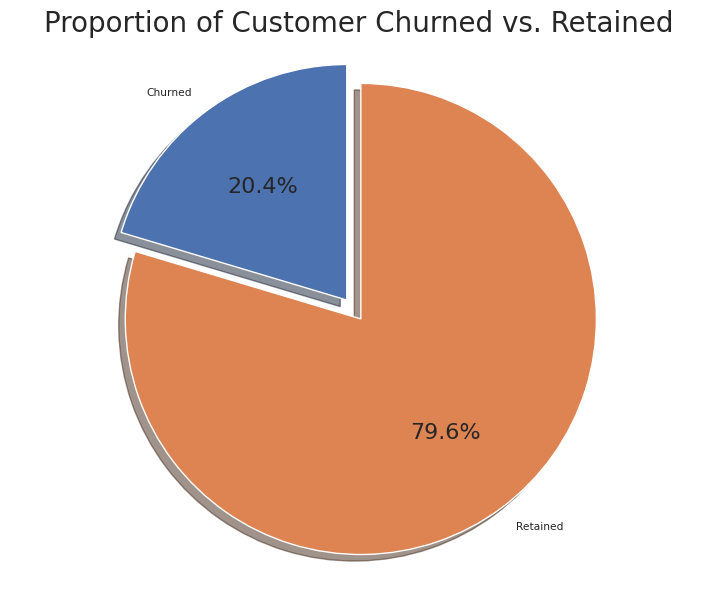

In [295]:
labels = 'Churned', 'Retained'
sizes = [
    df.Exited[df['Exited']==1].count(),
    df.Exited[df['Exited']==0].count()
]
explode = (0, 0.1)

fig1, ax1 = plt.subplots(figsize=(9, 7))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of Customer Churned vs. Retained", size = 20)
plt.show()

# 2.&nbsp;EDA


## 2.1 Data Preparation

In [296]:
dependent_variable_name = "Exited"

In [297]:
def show_unique_count_variables(df):
    for index, value in df.nunique().items():
        print(str(index) + "\n\t\t\t:" + str(value))

def data_prepare():
    df_prep = df.copy()

    missing_value_len = df.isnull().any().sum()
    if missing_value_len == 0:
        print("No Missing Value")
    else:
        print("Investigate Missing Value, Missing Value : " + str(missing_value_len))
    print("\n")

    show_unique_count_variables(df=df_prep)

    df_prep['Tenure'] = df_prep.Tenure.astype(np.float)
    df_prep['NumOfProducts'] = df_prep.NumOfProducts.astype(np.float)
    return df_prep

### 2.2. Outliers Observe (LOF method and Supress)
#### 2.2.1. Outlier Editing

In [298]:
def show_outliers(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_num_cols = df.select_dtypes(include=numerics)
    sns.set(font_scale=0.7)
    fig, axes = plt.subplots(
        nrows=2, ncols=5,
        gridspec_kw=dict(hspace=0.3), figsize=(12,9)
    )
    fig.tight_layout()
    for ax, col in zip(axes.flatten(), df_num_cols.columns):
        sns.boxplot(x=df_num_cols[col], color='green', ax=ax)
    fig.suptitle('Observing Outliers', color='r', fontsize=14)

#### 2.2.2. Visualization of outliers according to the LOF method

In [299]:
def lof_observation(df):

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_num_cols = df.select_dtypes(include=numerics)
    df_outlier = df_num_cols.astype("float64")
    clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    clf.fit_predict(df_outlier)
    df_scores = clf.negative_outlier_factor_
    scores_df = pd.DataFrame(np.sort(df_scores))

    scores_df.plot(
        stacked=True, xlim=[0,20], color='r',
        title='Visualization of outliers according to the LOF method',
        style='.-'); # first 20 observe

    th_val = np.sort(df_scores)[2]
    outliers = df_scores > th_val
    df = df.drop(df_outlier[~outliers].index)
    df.shape
    return df

#### 2.2.3. Outiler suppression

In [300]:
def clear_outliers(df):
    # For Age
    Q1 = df["Age"].quantile(0.25)
    Q3 = df["Age"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    print("When age and credit score is printed below lower score: ", lower, "and upper score: ", upper)
    df_outlier = df["Age"][(df["Age"] > upper)]
    df["Age"][df_outlier.index] = upper

    # For Credit Score
    Q1 = df["CreditScore"].quantile(0.25)
    Q3 = df["CreditScore"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    print("When age and credit score is printed above lower score: ", lower, "and upper score: ", upper)
    df_outlier = df["CreditScore"][(df["CreditScore"] < lower)]
    df["CreditScore"][df_outlier.index] = lower
    return df

#### 2.2.4. Outiler Process

In [301]:
def outlier_process(df):
    df_outlier = lof_observation(df = df)
    df_outlier = clear_outliers(df = df_outlier)
    return df_outlier

### 2.3. Data Analysis
#### 2.3.1. Dependent variable distribution

In [302]:
def show_dependent_variable(df):
    fig, axarr = plt.subplots(2, 3, figsize=(18, 6))
    sns.countplot(x='Geography', hue='Exited',data = df, ax = axarr[0][0])
    sns.countplot(x='Gender', hue='Exited',data = df, ax = axarr[0][1])
    sns.countplot(x='HasCrCard', hue='Exited',data = df, ax = axarr[0][2])
    sns.countplot(x='IsActiveMember', hue='Exited',data = df, ax = axarr[1][0])
    sns.countplot(x='NumOfProducts', hue='Exited',data = df, ax = axarr[1][1])
    sns.countplot(x='Tenure', hue='Exited',data = df, ax = axarr[1][2])
    zero, one = df[dependent_variable_name].value_counts()
    print("Dependent variable distribution;")
    print(dependent_variable_name + " 0 count:", zero)
    print(dependent_variable_name + " 1 count:", one)

#### 2.3.2. Numeric columns distribution observation

In [303]:
def show_numeric_columns_distributions(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_num_cols = df.select_dtypes(include=numerics)
    columns = df_num_cols.columns[: len(df_num_cols.columns)]
    fig = plt.figure()
    fig.set_size_inches(18, 15)
    length = len(columns)
    for i,j in itertools.zip_longest(columns, range(length)):
        plt.subplot(int(length/2), 3, j+1)
        plt.subplots_adjust(wspace=0.2, hspace=0.5)
        df_num_cols[i].hist(bins=20, edgecolor='black')
        plt.title(i)
    fig = fig.suptitle('Structures of numeric variables', color='r', fontsize=18)
    plt.show()

#### 2.3.3. Status of other variables according to dependent variable

In [304]:
def show_dependent_variable_cross_others_distributions(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_dependent_var = df[df[dependent_variable_name]==1]
    df_num_cols = df_dependent_var.select_dtypes(include=numerics)
    columns = df_num_cols.columns[:len(df_num_cols.columns)]

    fig = plt.figure()
    fig.set_size_inches(18, 15)
    length = len(columns)
    for i,j in itertools.zip_longest(columns, range(length)):
        plt.subplot(int(length/2), 3, j+1)
        plt.subplots_adjust(wspace=0.2, hspace=0.5)
        df_num_cols[i].hist(bins=20, edgecolor='black')
        plt.title(i)
    fig = fig.suptitle(dependent_variable_name + ' Status of other variables according to 1 dependent variable', color='r', fontsize=18)
    plt.show()

#### 2.3.4. Categorical variables are observed according to the dependent variable

In [305]:
def show_dependent_variable_cross_categorical_distributions(df, categorical_columns):
    sns.set(font_scale=0.7)
    fig, axes = plt.subplots(
        nrows=int(len(categorical_columns)/2 ),
        ncols=2,
        figsize=(7,9)
    )
    fig.tight_layout()
    for ax,col in zip(axes.flatten(), categorical_columns):
        sns.countplot(x=df[col], hue=dependent_variable_name, data=df, ax=ax)
    fig.suptitle('Categorical variables are monitored according to the dependent variable', color='r', fontsize=1)


#### 2.3.5. The main method that started all data analysis

In [306]:
def show_data_analysis(df):
    show_dependent_variable(df)
    show_numeric_columns_distributions(df)
    show_dependent_variable_cross_others_distributions(df)
    show_dependent_variable_cross_categorical_distributions(
        df=df_outlier,
        categorical_columns=["Gender", "Geography", "HasCrCard", "IsActiveMember"]
    )

## 3.&nbsp;Feature Engineering

In [307]:
def credit_score_table(row):
    credit_score = row.CreditScore
    if credit_score < 300:
      return "Deep"
    elif 300 <= credit_score < 500:
        return "Very_Poor"
    elif 500 <= credit_score < 601:
        return "Poor"
    elif 601 <= credit_score < 661:
        return "Fair"
    elif 661 <= credit_score < 781:
        return "Good"
    elif 781 <= credit_score < 851:
        return "Excellent"
    else:
        return "Top"

### 3.2. Product utilization RATE by YEAR

In [308]:
def product_utilization_rate_by_year(row):
    number_of_products = row.NumOfProducts
    tenure = row.Tenure

    if number_of_products == 0:
        return 0

    if tenure == 0:
        return number_of_products

    rate = number_of_products / tenure
    return rate

### 3.3. Product utilization rate by estimated SALARY

In [309]:
def product_utilization_rate_by_estimated_salary(row):
    number_of_products = row.number_of_products
    estimated_salary = row.EstimatedSalary

    if number_of_products == 0:
        return 0

    rate = number_of_products / estimated_salary
    return rate

### 3.4. According to countries monthly average salaries

reference: [Link](https://colab.research.google.com/drive/16-5XMNkJf8tPWw5L908_T-hpIwWlBkDw#scrollTo=pGT8KGG8b7LP&line=1&uniqifier=1)

In [310]:
def countries_monthly_average_salaries(row):
    fr = 3696
    de = 4740
    sp = 2257
    salary = row.EstimatedSalary / 12
    country = row.Geography # Germany, France and Spain

    if country == 'Germany':
        return salary / de
    elif country == "France":
        return salary / fr
    elif country == "Spain":
        return salary / sp

### 3.5. The main method that started all Feature Engineering

In [311]:
def feature_engineering(df, is_show_graph = False):
    df_fe = df.copy()

    balance_salary_rate = 'balance_salary_rate'
    df_fe[balance_salary_rate] = df_fe.Balance / df_fe.EstimatedSalary

    df_fe = df_fe.assign(
        product_utilization_rate_by_year=df_fe.apply(
            lambda x: product_utilization_rate_by_year(x),
            axis=1
            )
        )

    tenure_rate_by_age = 'tenure_rate_by_age'
    df_fe[tenure_rate_by_age] = df_fe.Tenure/(df_fe.Age-17)

    credit_score_rate_by_age = 'credit_score_rate_by_age'
    df_fe[credit_score_rate_by_age] = df_fe.CreditScore/(df_fe.Age-17)

    product_utilization_rate_by_salary = 'product_utilization_rate_by_salary'

    credit_score_rate_by_salary = 'credit_score_rate_by_salary'
    df_fe[credit_score_rate_by_salary] = df_fe.CreditScore/(df_fe.EstimatedSalary)

    if is_show_graph:
        fig, axes = plt.subplots(
            nrows=2, ncols=2, figsize=(20,12))
        fig.tight_layout()
        sns.boxplot(
            y=balance_salary_rate,
            x=dependent_variable_name,
            hue=dependent_variable_name,
            data=df_fe,
            ax=axes[0][0]
        )
        sns.boxplot(
            y=product_utilization_rate_by_year,
            x=dependent_variable_name,
            hue=dependent_variable_name,
            data=df_fe,
            ax=axes[0][1]
        )
        plt.ylim(-1, 5)

    df_fe = df_fe.assign(credit_score_table=df_fe.apply(lambda x: credit_score_table(x), axis=1))
    df_fe = df_fe.assign(countries_monthly_average_salaries = df_fe.apply(lambda x: countries_monthly_average_salaries(x), axis=1))
    return df_fe

# 4.&nbsp;Data Encoding

In [312]:
def data_encoding(df):
    df_model = df.copy()
    # >>>> Categorical columns <<<<<
    non_encoding_columns = [
        "Geography", "HasCrCard","IsActiveMember",
        "Gender", "NumOfProducts", "Tenure","credit_score_table"]

    df_non_encoding = df_model[non_encoding_columns]
    df_model = df_model.drop(non_encoding_columns,axis=1)
    df_encoding = df_non_encoding.copy()

    encoder = LabelEncoder()
    df_encoding["gender_category"] = encoder.fit_transform(df_non_encoding.Gender)
    df_encoding["country_category"] = encoder.fit_transform(df_non_encoding.Geography)
    df_encoding["credit_score_category"] = encoder.fit_transform(df_non_encoding.credit_score_table)

    df_encoding.reset_index(drop=True, inplace=True)
    df_model.reset_index(drop=True, inplace=True)
    df_model = pd.concat([df_model, df_encoding], axis=1)

    df_model = df_model.drop(
        ["Geography", "Gender" ,"CustomerId", "Surname",
         "credit_score_table", "CreditScore", "EstimatedSalary"],
        axis=1)

    df_model = df_model.reset_index()
    df_model = df_model.drop('index', axis=1)

    df_model.loc[df_model.HasCrCard==0, 'credit_card_situation'] = -1
    df_model.loc[df_model.IsActiveMember==0, 'is_active_member'] = -1
    return df_model

# 5.&nbsp;Model Preparation

In [313]:
def model_prepare(df_model):
    y = df_model[dependent_variable_name]
    X = df_model.loc[:, df_model.columns != dependent_variable_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform (X_test)
    return X_train, X_test, y_train, y_test

### 5.1 Part of Data Train

In [314]:
def data_training(X_train, X_test, y_train, y_test):

    models = []
    models.append(('LOGR',LogisticRegression()))
    models.append(('KNN',KNeighborsClassifier()))
    models.append(('CART',DecisionTreeClassifier()))
    models.append(('RF',RandomForestClassifier()))
    models.append(('GBM',GradientBoostingClassifier()))
    models.append(('XGBoost',XGBClassifier()))
    models.append(('LightGBM',LGBMClassifier()))

    res_cols = [
        'model','accuracy_score','scale_method',
        "0_precision","0_recall","1_precision","1_recall"
    ]
    df_result = pd.DataFrame(columns=res_cols)

    index = 0
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, digits=2, output_dict=True)
        zero_report = class_report['0']
        one_report = class_report['1']
        res_vals = [name, score, "NA", zero_report['precision'], zero_report['recall'], one_report['precision'], one_report['recall']]
        df_result.at[index, res_cols] = res_vals
        index += 1
    return df_result.sort_values("accuracy_score", ascending=False)

# 6.&nbsp;HELPER Functions

In [315]:
# Function to give best model score and parameters

def best_model(model):
    print(model.best_score_)
    print(model.best_params_)
    print(model.best_estimator_)

def get_auc_scores(y_actual, method,method2):
    auc_score = roc_auc_score(y_actual, method);
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2);
    return (auc_score, fpr_df, tpr_df)

from matplotlib import rc, rcParams
def plot_confusion_matrix(
    cm, classes,
    normalize=False,
    title='Confusion Matrix',
    cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    plt.rcParams.update({'font.size': 16})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, color="blue")
    plt.yticks(tick_marks, classes, color="blue")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 7.&nbsp;Data Cleaning

No Missing Value


CustomerId
			:10000
Surname
			:2932
CreditScore
			:460
Geography
			:3
Gender
			:2
Age
			:70
Tenure
			:11
Balance
			:6382
NumOfProducts
			:4
HasCrCard
			:2
IsActiveMember
			:2
EstimatedSalary
			:9999
Exited
			:2
When age and credit score is printed below lower score:  14.0 and upper score:  62.0
When age and credit score is printed above lower score:  383.0 and upper score:  919.0


<ipython-input-300-88e44ad234b5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Age"][df_outlier.index] = upper
<ipython-input-300-88e44ad234b5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CreditScore"][df_outlier.index] = lower


Dependent variable distribution;
Exited 0 count: 7963
Exited 1 count: 2037


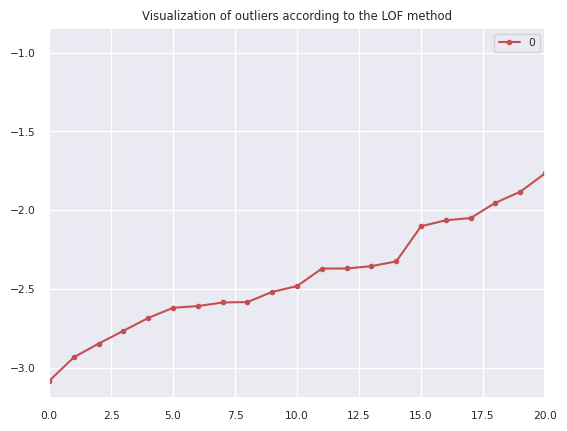

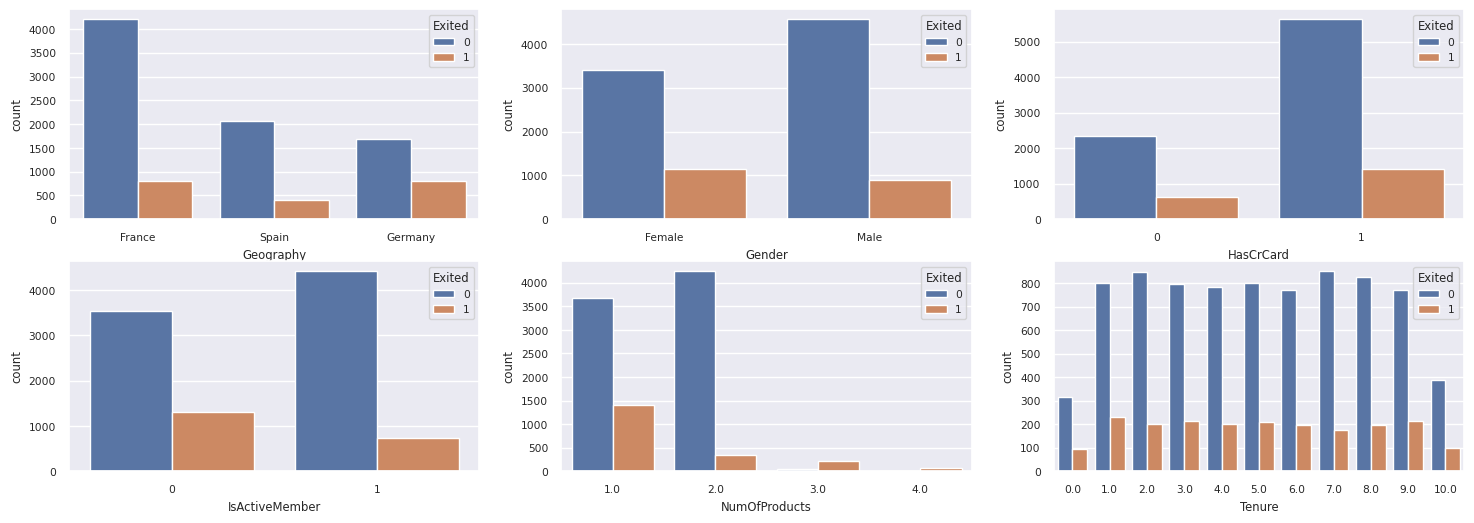

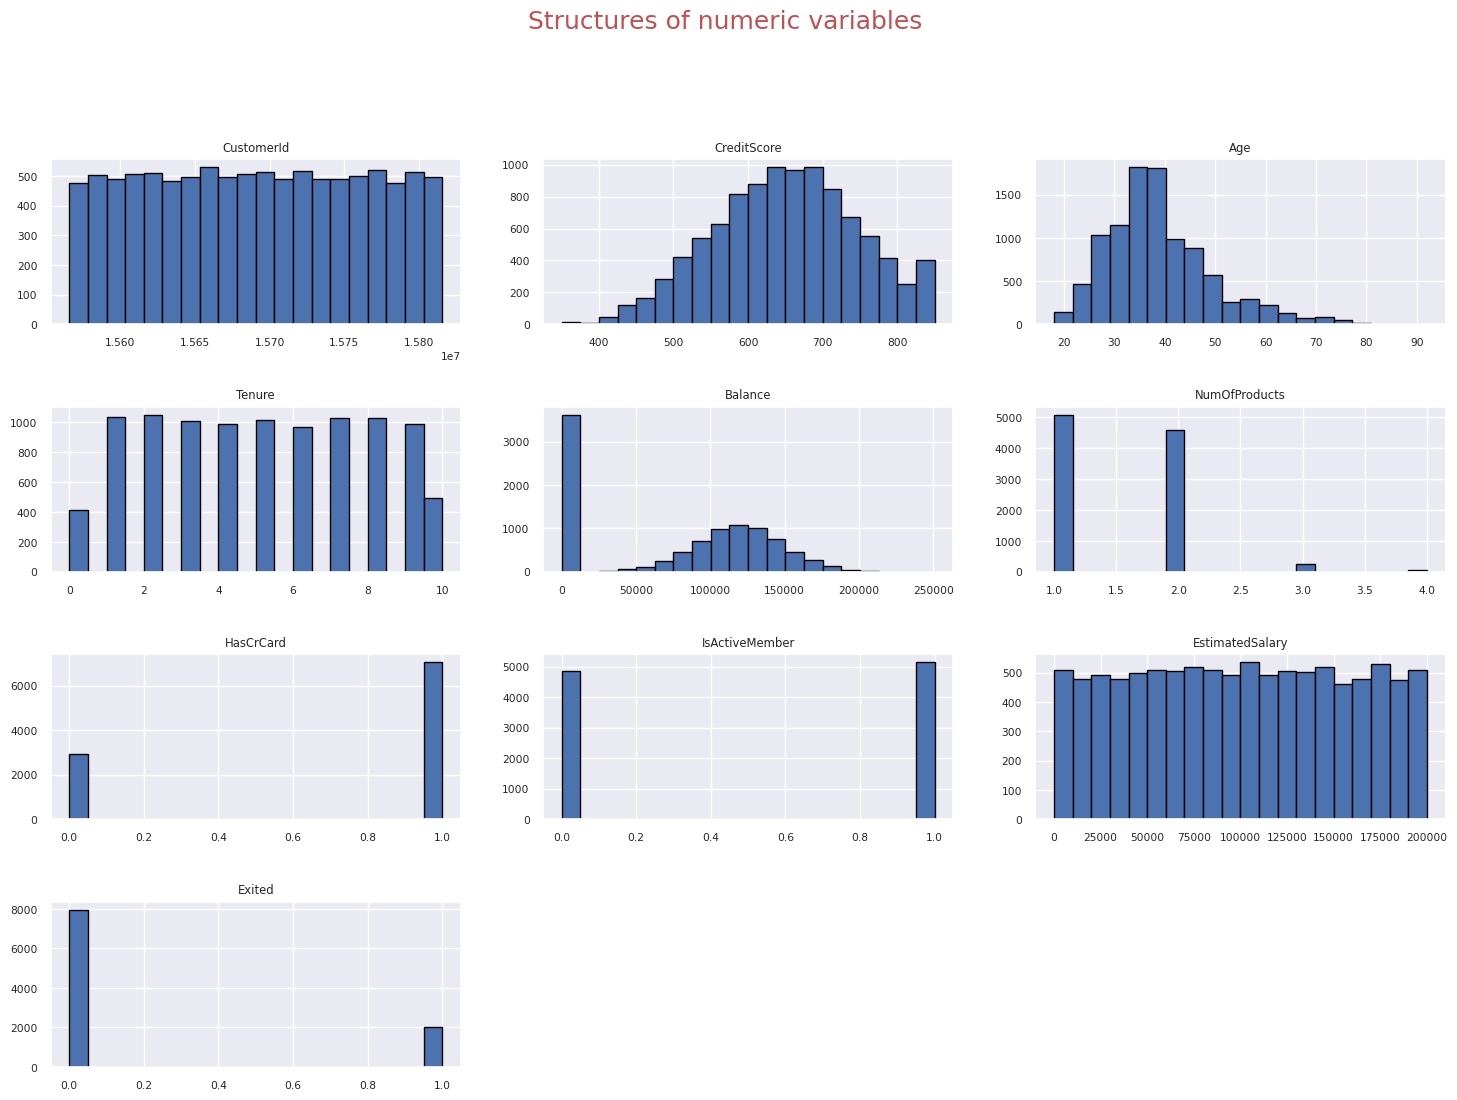

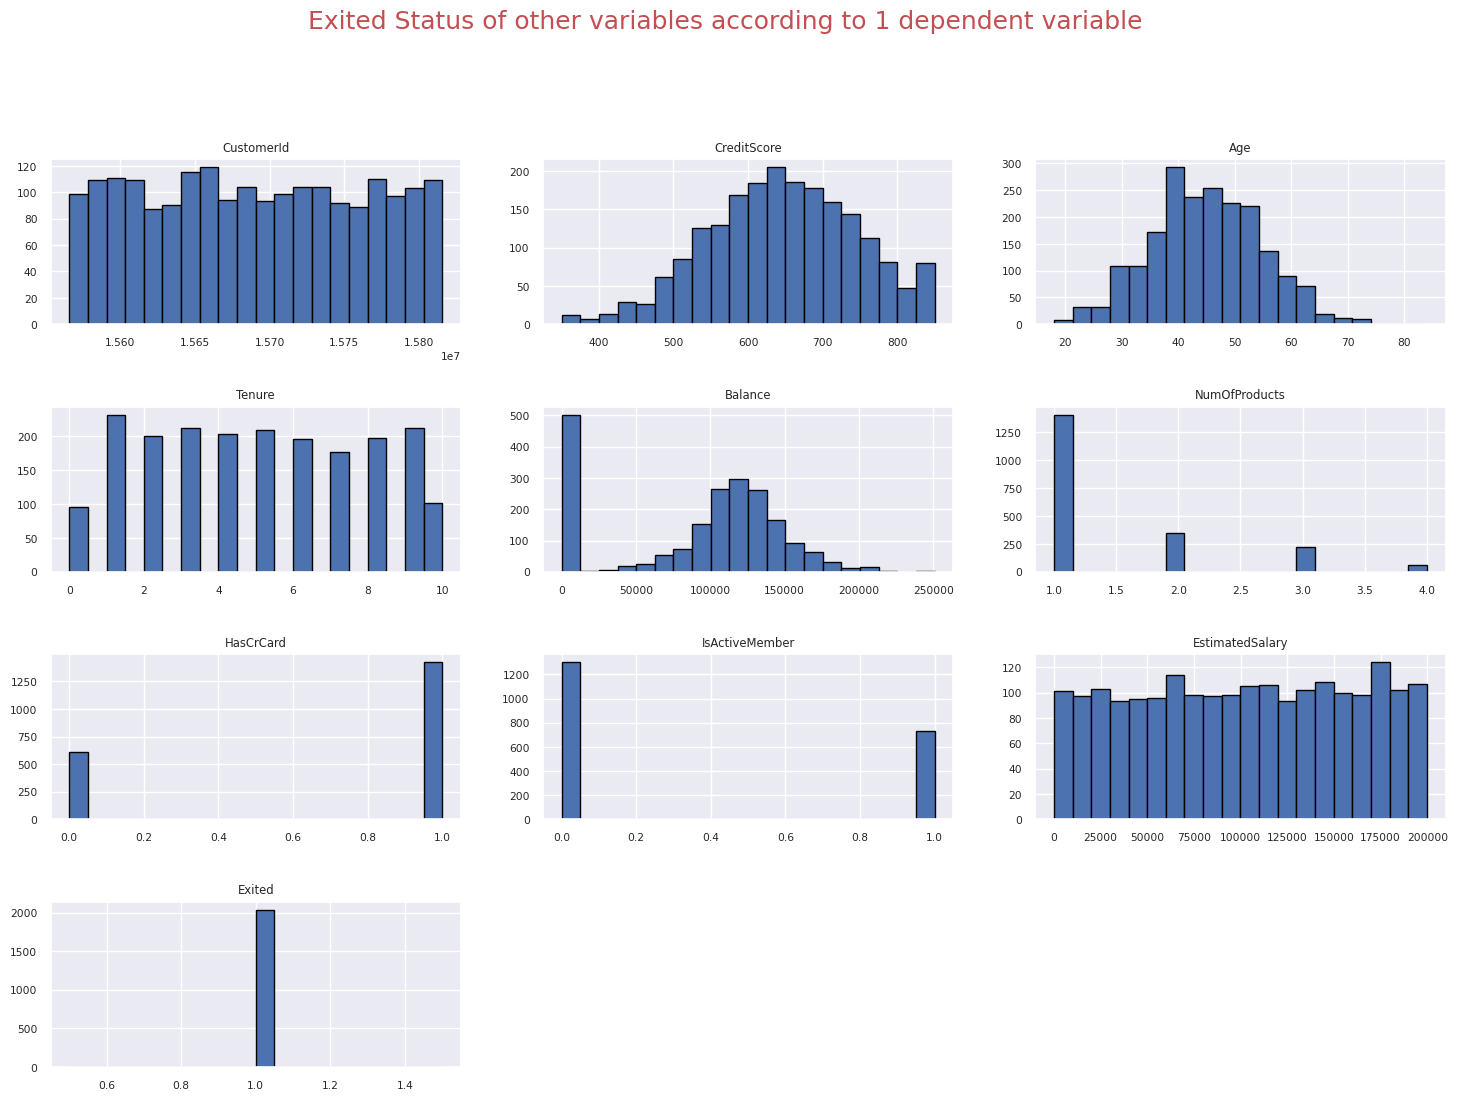

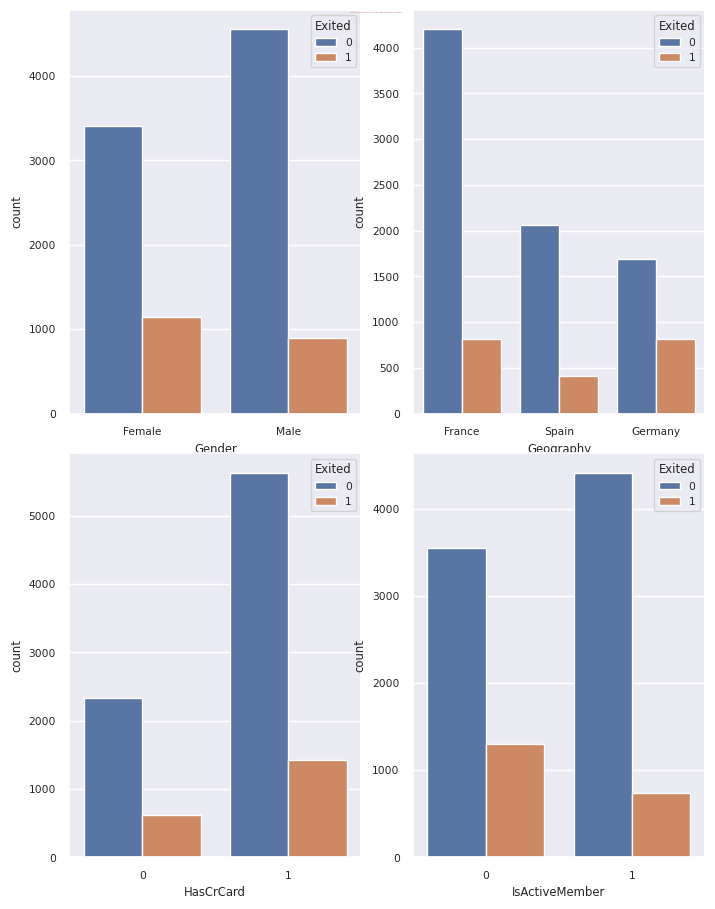

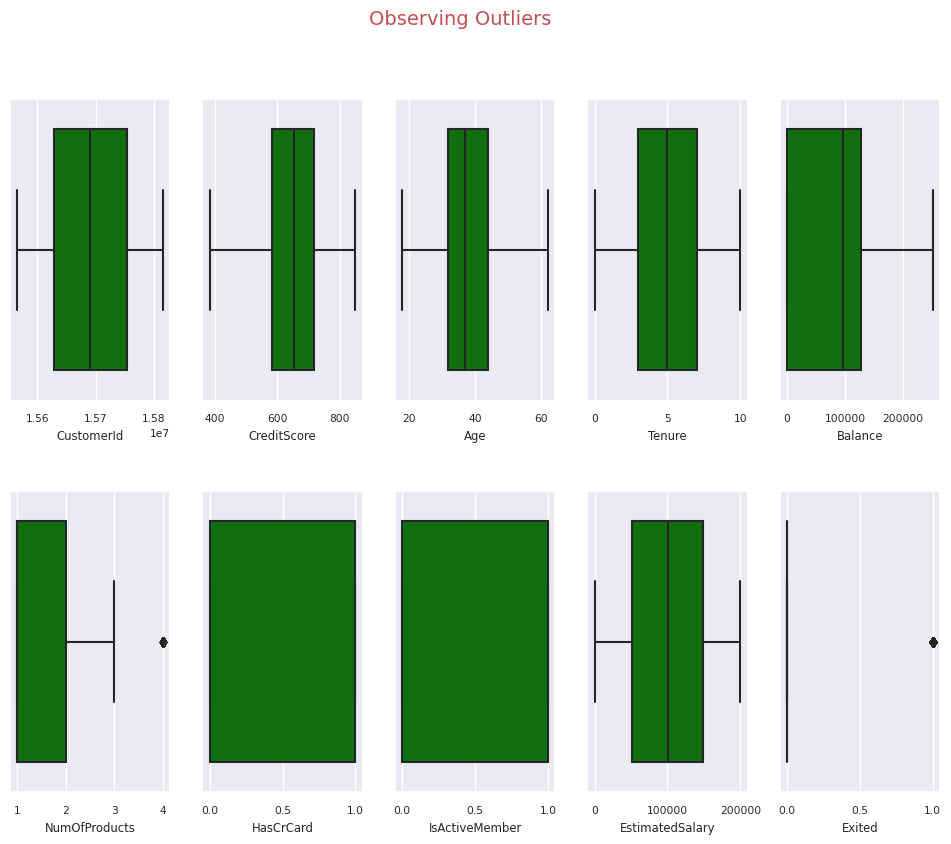

In [316]:
df_prep = data_prepare()
df_outlier = outlier_process(df = df_prep)

show_data_analysis(df_prep)
show_outliers(df = df_outlier)

Let's see after feature engineering:

In [317]:
df_fe = feature_engineering(df = df_outlier)
df_fe.head(3)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,balance_salary_rate,product_utilization_rate_by_year,tenure_rate_by_age,credit_score_rate_by_age,credit_score_rate_by_salary,credit_score_table,countries_monthly_average_salaries
RowNumber,,,,,,,,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1.00,1,1,101348.88,1,0.00,0.50,0.08,24.76,0.01,Fair,2.29
2,15647311,Hill,608,Spain,Female,41,1.00,83807.86,1.00,0,1,112542.58,0,0.74,1.00,0.04,25.33,0.01,Fair,4.16
3,15619304,Onio,502,France,Female,42,8.00,159660.80,3.00,1,0,113931.57,1,1.40,0.38,0.32,20.08,0.00,Poor,2.57


And see after data encoding:

In [318]:
df_encoded = data_encoding(df_fe)
df_encoded.drop(
    columns=['credit_card_situation', 'is_active_member'], inplace=True)
df_encoded.head(5)

,Age,Balance,Exited,balance_salary_rate,product_utilization_rate_by_year,tenure_rate_by_age,credit_score_rate_by_age,credit_score_rate_by_salary,countries_monthly_average_salaries,HasCrCard,IsActiveMember,NumOfProducts,Tenure,gender_category,country_category,credit_score_category
0,42,0.00,1,0.00,0.50,0.08,24.76,0.01,2.29,1,1,1.00,2.00,0,0,1
1,41,83807.86,0,0.74,1.00,0.04,25.33,0.01,4.16,0,1,1.00,1.00,0,2,1
2,42,159660.80,1,1.40,0.38,0.32,20.08,0.00,2.57,1,0,3.00,8.00,0,0,3
3,39,0.00,0,0.00,2.00,0.05,31.77,0.01,2.12,0,0,2.00,1.00,0,0,2
4,43,125510.82,0,1.59,0.50,0.08,32.69,0.01,2.92,1,1,1.00,2.00,0,2,0


Now, let's see correlation graph:

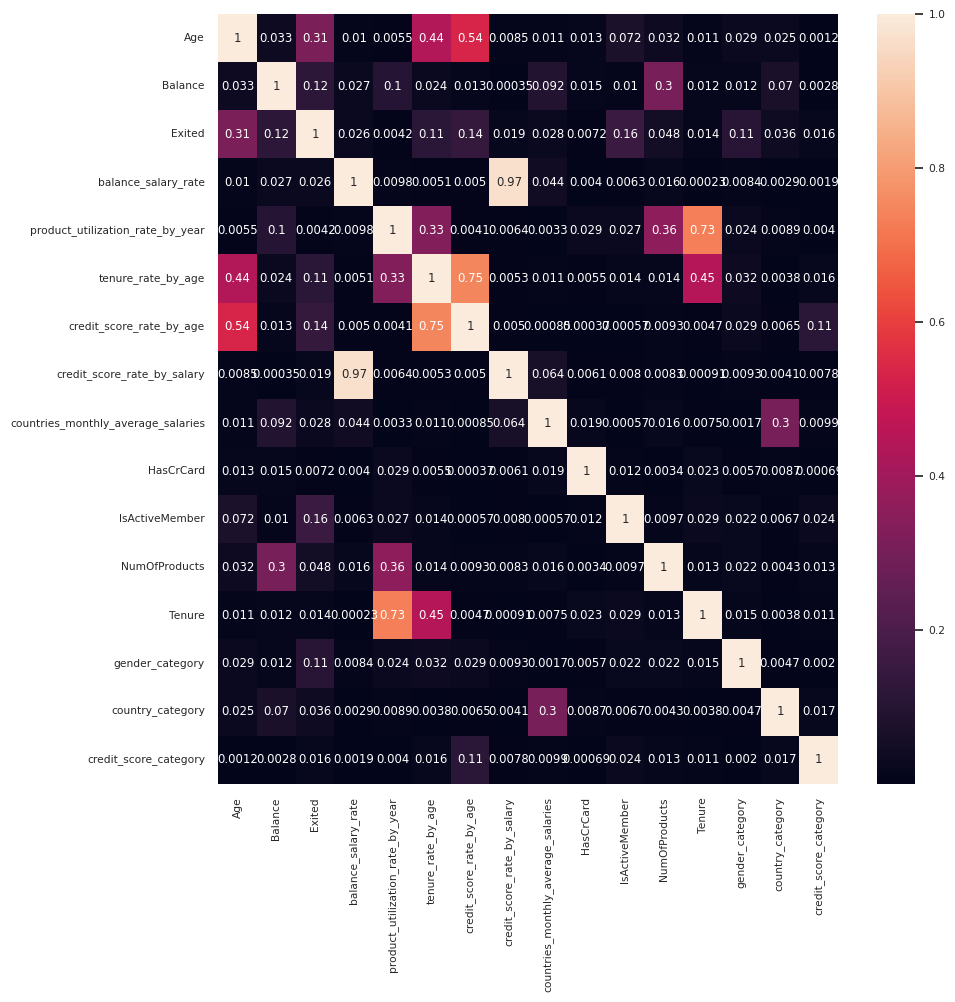

In [319]:
correlation = df_encoded.corr().abs()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, annot=True)
plt.show()

List of correlation scores:

In [320]:
corrs_results = df_encoded.corrwith(df_encoded["Exited"]).abs().nlargest(24)
corrs_results

Exited                               1.00
Age                                  0.31
IsActiveMember                       0.16
credit_score_rate_by_age             0.14
Balance                              0.12
tenure_rate_by_age                   0.11
gender_category                      0.11
NumOfProducts                        0.05
country_category                     0.04
countries_monthly_average_salaries   0.03
balance_salary_rate                  0.03
credit_score_rate_by_salary          0.02
credit_score_category                0.02
Tenure                               0.01
HasCrCard                            0.01
product_utilization_rate_by_year     0.00
dtype: float64

# Imbalance Data

In [321]:
# Menyeimbangkan data menggunakan SMOTE
X = df_encoded.drop('Exited', axis=1)
y = df_encoded['Exited']

print("Jumlah sampel sebelum SMOTE:", Counter(y))

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Jumlah sampel setelah SMOTE:", Counter(y_resampled))

Jumlah sampel sebelum SMOTE: Counter({0: 7961, 1: 2036})
Jumlah sampel setelah SMOTE: Counter({1: 7961, 0: 7961})


# 8.&nbsp;Apply Model

In [322]:
# # model_prepare test, train split 0.2
# X_train, X_test, y_train, y_test = model_prepare(df_model=df_encoded)

# Memisahkan data menjadi data pelatihan dan data pengujian menggunakan data yang sudah balace
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

### 8.1. Logistic Regression Model

Have a look with Logistic Regression.

In [323]:
logr_model = LogisticRegression()
logr_model.fit(X_train, y_train)
y_pred = logr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred, digits=4))
print("Accuracy score of Logistic Regression: ", accuracy)

              precision    recall  f1-score   support

           0     0.7346    0.6016    0.6615      1624
           1     0.6512    0.7739    0.7073      1561

    accuracy                         0.6860      3185
   macro avg     0.6929    0.6877    0.6844      3185
weighted avg     0.6937    0.6860    0.6839      3185

Accuracy score of Logistic Regression:  0.6860282574568289


### 8.2. Model Training

This is for all LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, XGBClassifier, and LGBMClassifier model objects:

In [324]:
def data_training(X_train, X_test, y_train, y_test):

    models = []
    models.append(('LOGR', LogisticRegression()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('GBM', GradientBoostingClassifier()))
    models.append(('XGBoost', XGBClassifier()))
    models.append(('LightGBM', LGBMClassifier()))

    res_cols = ["model", "accuracy_score", "scale_method", "0_precision", "0_recall", "1_precision", "1_recall"]
    df_result = pd.DataFrame(columns=res_cols)
    index = 0
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, digits=2, output_dict=True)
        zero_report = class_report['0']
        one_report = class_report['1']

        idx_res_values = [name, score, "NA", zero_report['precision'], zero_report['recall'], one_report['precision'], one_report['recall']]
        # df_result.at[index, res_cols] = idx_res_values
        df_result.loc[index, res_cols] = idx_res_values
        index += 1
    df_result = df_result.sort_values("accuracy_score", ascending=False).reset_index(drop=True)
    return df_result

In [325]:
# accuration with imbalance dataset
# print("Accuration accuration with imbalance dataset ")
# training_result = data_training(X_train, X_test, y_train, y_test)
# training_result

In [326]:
# accuration without imbalance dataset
print("Accuration accuration without imbalance dataset ")
training_result = data_training(X_train, X_test, y_train, y_test)
training_result

Accuration accuration without imbalance dataset 


,model,accuracy_score,scale_method,0_precision,0_recall,1_precision,1_recall
0,LightGBM,0.90,NA,0.89,0.93,0.92,0.87
1,XGBoost,0.90,NA,0.89,0.93,0.92,0.88
2,RF,0.89,NA,0.87,0.91,0.90,0.86
3,GBM,0.89,NA,0.87,0.91,0.90,0.86
4,CART,0.83,NA,0.84,0.83,0.83,0.84
5,KNN,0.74,NA,0.78,0.66,0.70,0.81
6,LOGR,0.69,NA,0.73,0.60,0.65,0.77


# 9.&nbsp;Model Tuning

### 9.1. XGBoost Tuning

In [327]:
xgb_model=XGBClassifier(
    learning_rate=0.23, max_delta_step=5,
    objective='reg:logistic', n_estimators=92,
    max_depth=5, eval_metric="logloss", gamma=3, base_score=0.5)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=2))
print("Accuracy score of Tuned XGBoost Regression: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1624
           1       0.92      0.87      0.90      1561

    accuracy                           0.90      3185
   macro avg       0.90      0.90      0.90      3185
weighted avg       0.90      0.90      0.90      3185

Accuracy score of Tuned XGBoost Regression:  0.8998430141287285


### 9.2. Random Forest Tuning

In [328]:
'''
param_grid = {
    'max_depth': [3, 5, 6, 7, 8],
    'max_features': [2, 4, 6, 7, 8, 9],
    'n_estimators' : [50, 100],
    'min_samples_split': [3, 5, 6, 7]
}

randFor_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5, refit = True, verbose = 0)
randFor_grid.fit(X_train, y_train)
best_model(randFor_grid)
'''

# skipped, running too long

"\nparam_grid = {\n    'max_depth': [3, 5, 6, 7, 8],\n    'max_features': [2, 4, 6, 7, 8, 9],\n    'n_estimators' : [50, 100],\n    'min_samples_split': [3, 5, 6, 7]\n}\n\nrandFor_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5, refit = True, verbose = 0)\nrandFor_grid.fit(X_train, y_train)\nbest_model(randFor_grid)\n"

Using the parameters and get final version accuracy score.

In [329]:
rnd_model = RandomForestClassifier(
    max_depth=8,
    max_features=6,
    min_samples_split=6,
    n_estimators=50
)

rnd_model.fit(X_train, y_train)
y_pred = rnd_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=2))
print("Accuracy score of tuned Random Forest model: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1624
           1       0.87      0.85      0.86      1561

    accuracy                           0.87      3185
   macro avg       0.87      0.87      0.87      3185
weighted avg       0.87      0.87      0.87      3185

Accuracy score of tuned Random Forest model:  0.865934065934066


### 9.3. LightGBM Tuning

In [330]:
lgbm_model = LGBMClassifier(
    silent = 0, learning_rate = 0.09, max_delta_step = 2,
    n_estimators = 100, boosting_type = 'gbdt',
    max_depth = 10, eval_metric = "logloss",
    gamma = 3, base_score = 0.5
)

lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=2))
print("Accuracy score of tuned LightGBM model: ", accuracy_score(y_test, y_pred))

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 6400, number of negative: 6337
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2349
[LightGBM] [Info] Number of data points in the train set: 12737, number of used features: 15
[LightGBM] [Info]

# 10.&nbsp;Confusion Matrix

Confusion matrix, without normalization
True Negatives:  1512
False Positives:  112
False Negatives:  197
True Positives:  1364


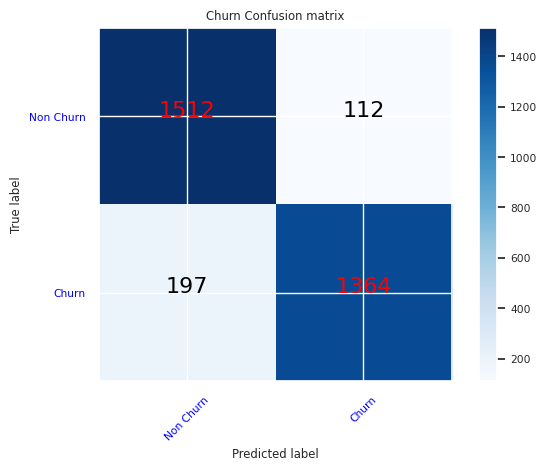

In [331]:
cfm = confusion_matrix(y_test, y_pred=y_pred)
plot_confusion_matrix(
    cfm,
    normalize=False,
    classes=['Non Churn','Churn'],
    title='Churn Confusion matrix'
)

tn, fp, fn, tp = cfm.ravel()

print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

# 11.&nbsp;ROC Curve

In [332]:
!pip install scikit-plot

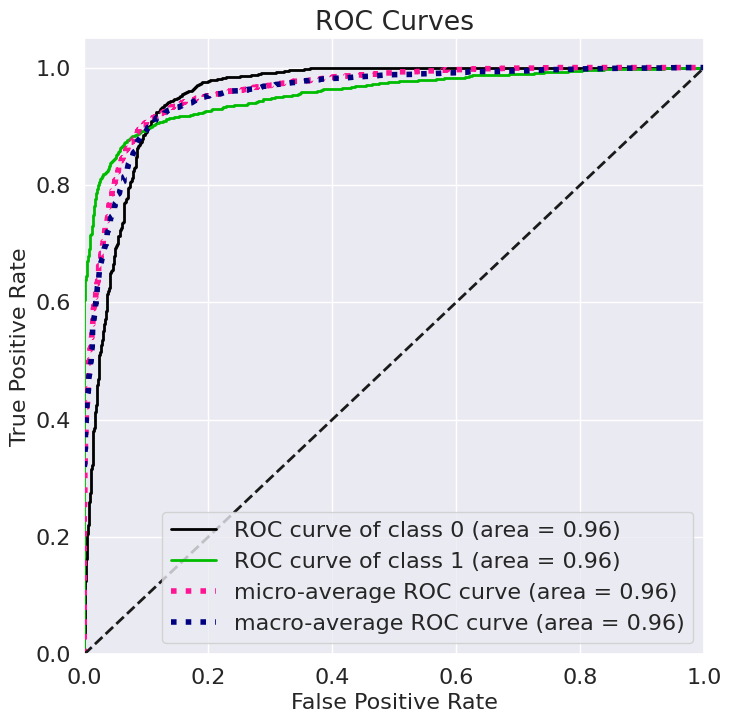

In [333]:
import scikitplot as skplt
y_pred_proba = lgbm_model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_proba, figsize=(8,8))

plt.show()

# 12.&nbsp;Feature Importance

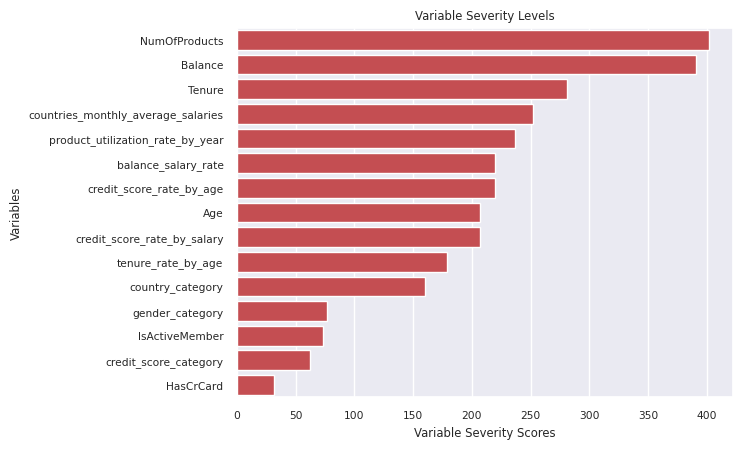

In [334]:
feature_index = df_encoded.loc[:, df_encoded.columns != dependent_variable_name]

feature_importance = pd.Series(
    lgbm_model.feature_importances_,
    index=feature_index.columns
)
feature_importance = feature_importance.sort_values(ascending=False)

sns.barplot(
    x=feature_importance,
    y=feature_importance.index,
    color='r',
    saturation=1
)

plt.xlabel('Variable Severity Scores')
plt.ylabel('Variables')
plt.title('Variable Severity Levels')
plt.show()

# 13.&nbsp;Conclusion



*  Penggunaan teknik SMOTE pada dataset yang tidak seimbang dapat meningkatkan kinerja model dengan mengatasi ketidakseimbangan dan meningkatkan akurasi dalam memprediksi kelas minoritas.

*  Model machine learning LightGBM tuning yang telah dituning menunjukkan tingkat akurasi yang tinggi dibandingkan dengan model lain dalam kasus klasifikasi churn atau tidak.

*  Variabel NumOfProducts dan Balance dianggap memiliki pengaruh signifikan dalam prediksi churn (pelanggan keluar) dalam model.

*  Ketika model prediksi churn memiliki False Negative yang tinggi, perusahaan berisiko kehilangan pelanggan penting karena mereka yang sebenarnya akan churn tidak terdeteksi, mengurangi kesempatan untuk mencegah kepergian mereka. Penting untuk meningkatkan kualitas model agar dapat lebih efektif dalam memprediksi pelanggan yang berpotensi churn.

*  Balancing belum berhasil meningkatkan performa model dengan cukup baik sehingga False Negative menjadi lebih tinggi setelah proses balancing. Hal ini mungkin dikarenakan semakin banyak data(data setelah balancing) maka semakin banyak kemungkinan data terprediksi salah.